In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2024-01-05 20:20:36.615271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
epochs = 10 

In [3]:
import yfinance as yf

# Download Bitcoin data from Yahoo Finance

btc_data = yf.download('BTC-USD', period='3600d')  # Bitcoin verilerini yfinance ile indirme
df = btc_data[['Open', 'High', 'Low', 'Close' , 'Adj Close', 'Volume']]  # İlgili sütunların seçilmesi

df.head()  # İlk 5 satırın gösterilmesi

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Looking good! Let's get some more info.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3398 entries, 2014-09-17 to 2024-01-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3398 non-null   float64
 1   High       3398 non-null   float64
 2   Low        3398 non-null   float64
 3   Close      3398 non-null   float64
 4   Adj Close  3398 non-null   float64
 5   Volume     3398 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 185.8 KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [5]:
# How many samples do we have?
len(df)

3398

In [6]:
import pandas as pd

# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

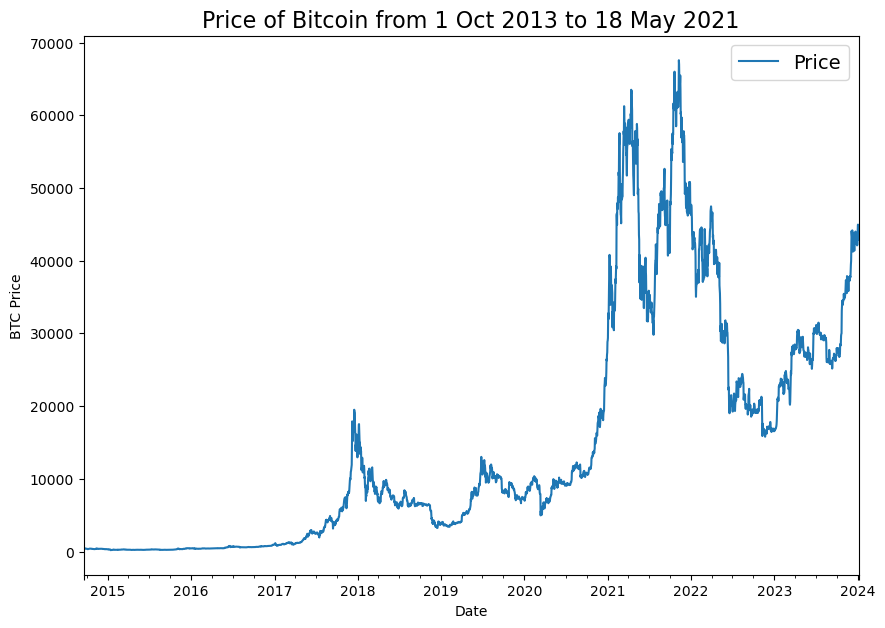

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

In [8]:
# Formatting historical Bitcoin data with Python
from datetime import datetime

timesteps = []
btc_price = []


# ilk 10 satırın gösterilmesi
for row in df.itertuples():
  timesteps.append(row.Index)
  btc_price.append(row.Close)





timesteps[:10], btc_price[:10]

([Timestamp('2014-09-17 00:00:00'),
  Timestamp('2014-09-18 00:00:00'),
  Timestamp('2014-09-19 00:00:00'),
  Timestamp('2014-09-20 00:00:00'),
  Timestamp('2014-09-21 00:00:00'),
  Timestamp('2014-09-22 00:00:00'),
  Timestamp('2014-09-23 00:00:00'),
  Timestamp('2014-09-24 00:00:00'),
  Timestamp('2014-09-25 00:00:00'),
  Timestamp('2014-09-26 00:00:00')],
 [457.3340148925781,
  424.44000244140625,
  394.7959899902344,
  408.90399169921875,
  398.8210144042969,
  402.1520080566406,
  435.7909851074219,
  423.2049865722656,
  411.5740051269531,
  404.42498779296875])

Beautiful! Now, let's see how things look.

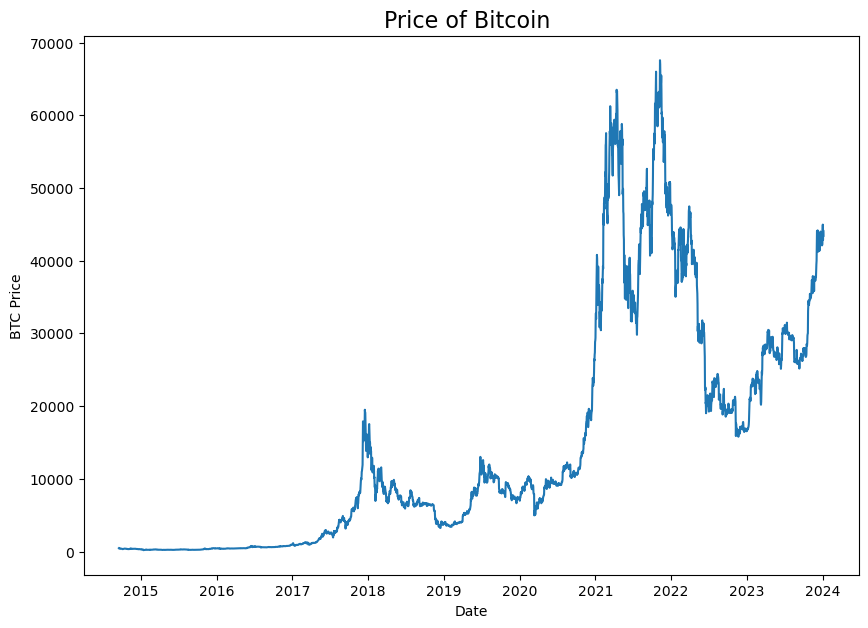

In [9]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin ", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

Ho ho! Would you look at that! Just like the pandas plot. And because we formatted the `timesteps` to be `datetime` objects, `matplotlib` displays a fantastic looking date axis.

In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.33401489, 424.44000244, 394.79598999, 408.9039917 ,
        398.8210144 , 402.15200806, 435.79098511, 423.20498657,
        411.57400513, 404.42498779]))

## Format Data Part 1: Creatining train and test sets for time series data



Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what *kind* of data we have.

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![comparison of univariate and multivariate time series data](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)
*Example of univariate and multivariate time series data. Univariate involves using the target to predict the target. Multivariate inolves using the target as well as another time series to predict the target.*

### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2718, 680, 2718, 680)

Okay, looks like our custom made splits are the same lengths as the splits we made with `train_test_split`.

But again, these are numbers on a page.

And you know how the saying goes, trust one eye more than two ears.

Let's visualize.

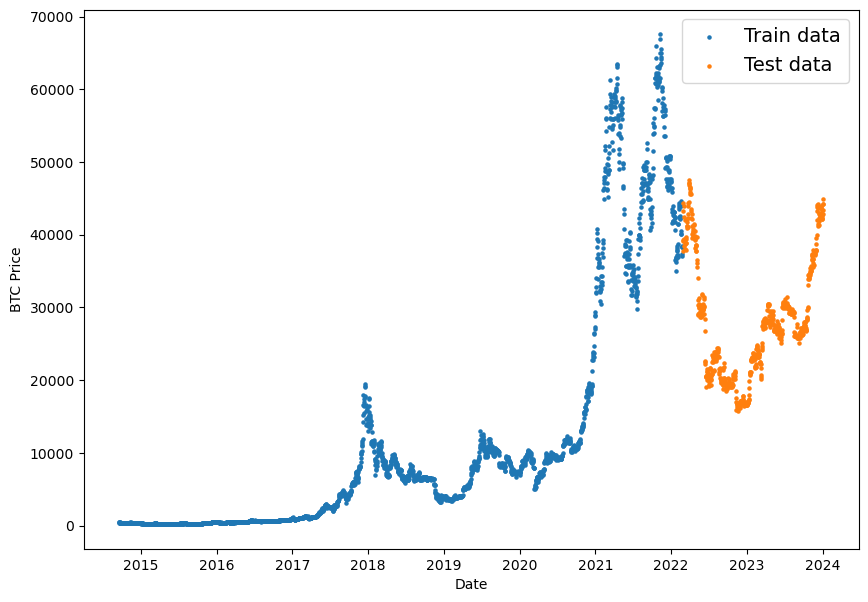

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

That looks much better!

Do you see what's happened here?

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can guage how our model might perform on *actual* future data.

> 🔑 **Note:** The amount of data you reserve for your test set not set in stone. You could have 80/20, 90/10, 95/5 splits or in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 **Resource:** Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data, I'd recommend reading it.



### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

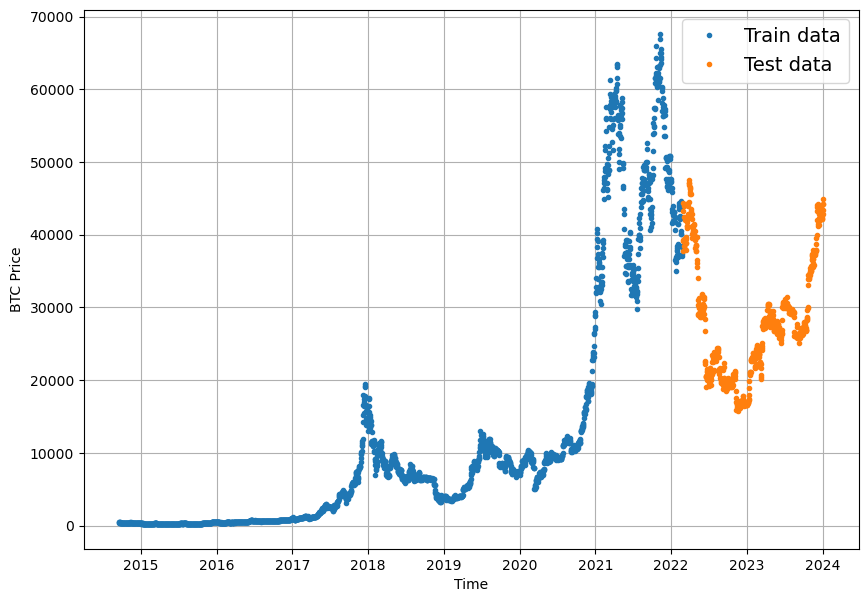

In [14]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Looking good!

Time for some modelling experiments.

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [15]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [16]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Looking good! How about we test our function on the naive forecast?

In [17]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

27630.505408432906

## Format Data Part 2: Windowing dataset

Surely we'd be ready to start building models by now?

We're so close! Only one more step (really two) to go.

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [18]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [19]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [20]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Oh yeah, that's what I'm talking about!

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [21]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Phew! A few steps there... let's see how it goes.

In [22]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3391, 3391)

Of course we have to visualize, visualize, visualize!

In [23]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511] -> Label: [423.20498657]
Window: [424.44000244 394.79598999 408.9039917  398.8210144  402.15200806
 435.79098511 423.20498657] -> Label: [411.57400513]
Window: [394.79598999 408.9039917  398.8210144  402.15200806 435.79098511
 423.20498657 411.57400513] -> Label: [404.42498779]


In [24]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [43442.85546875 42627.85546875 42099.40234375 42156.90234375
 42265.1875     44167.33203125 44957.96875   ] -> Label: [42848.17578125]
Window: [42627.85546875 42099.40234375 42156.90234375 42265.1875
 44167.33203125 44957.96875    42848.17578125] -> Label: [44179.921875]
Window: [42099.40234375 42156.90234375 42265.1875     44167.33203125
 44957.96875    42848.17578125 44179.921875  ] -> Label: [43413.40234375]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets 

Look how good those windows look! Almost like the stain glass windows on the Sistine Chapel, well, maybe not that good but still.

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [25]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

Look at that amazing function, lets test it.

In [26]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2712, 679, 2712, 679)

Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

How do the first 5 samples of the training windows and labels looks?

In [27]:
train_windows[:5], train_labels[:5]

(array([[457.33401489, 424.44000244, 394.79598999, 408.9039917 ,
         398.8210144 , 402.15200806, 435.79098511],
        [424.44000244, 394.79598999, 408.9039917 , 398.8210144 ,
         402.15200806, 435.79098511, 423.20498657],
        [394.79598999, 408.9039917 , 398.8210144 , 402.15200806,
         435.79098511, 423.20498657, 411.57400513],
        [408.9039917 , 398.8210144 , 402.15200806, 435.79098511,
         423.20498657, 411.57400513, 404.42498779],
        [398.8210144 , 402.15200806, 435.79098511, 423.20498657,
         411.57400513, 404.42498779, 399.51998901]]),
 array([[423.20498657],
        [411.57400513],
        [404.42498779],
        [399.51998901],
        [377.18099976]]))

In [28]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

## Make a modelling checkpoint

We're so close to building models. So so so close.

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

> 🔑 **Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [29]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

Finally!

Time to build one of our models.

If you think we've been through a fair bit of preprocessing before getting here, you're right.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

Why these values?

I picked them out of experimentation. 

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 **Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=epochs,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/10
 1/22 [>.............................] - ETA: 12s - loss: 14099.2910 - mae: 14099.2910INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


22/22 [==============================] - 1s 26ms/step - loss: 10553.1357 - mae: 10553.1357 - val_loss: 4838.4683 - val_mae: 4838.4683
Epoch 2/10
 1/22 [>.............................] - ETA: 0s - loss: 2113.9971 - mae: 2113.9971INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


22/22 [==============================] - 0s 13ms/step - loss: 1220.1038 - mae: 1220.1038 - val_loss: 1968.3737 - val_mae: 1968.3737
Epoch 3/10
 1/22 [>.............................] - ETA: 0s - loss: 820.9976 - mae: 820.9976INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


22/22 [==============================] - 0s 13ms/step - loss: 644.7603 - mae: 644.7603 - val_loss: 919.8962 - val_mae: 919.8962
Epoch 4/10
22/22 [==============================] - 0s 2ms/step - loss: 562.7791 - mae: 562.7791 - val_loss: 979.5381 - val_mae: 979.5381
Epoch 5/10
 1/22 [>.............................] - ETA: 0s - loss: 664.4972 - mae: 664.4972INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


22/22 [==============================] - 0s 14ms/step - loss: 546.0077 - mae: 546.0077 - val_loss: 840.8304 - val_mae: 840.8304
Epoch 6/10
 1/22 [>.............................] - ETA: 0s - loss: 365.8801 - mae: 365.8801INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


22/22 [==============================] - 0s 14ms/step - loss: 507.7801 - mae: 507.7801 - val_loss: 761.1916 - val_mae: 761.1916
Epoch 7/10
 1/22 [>.............................] - ETA: 0s - loss: 515.1293 - mae: 515.1293INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


22/22 [==============================] - 0s 13ms/step - loss: 487.3101 - mae: 487.3101 - val_loss: 741.6421 - val_mae: 741.6421
Epoch 8/10
22/22 [==============================] - 0s 2ms/step - loss: 480.0519 - mae: 480.0519 - val_loss: 771.3146 - val_mae: 771.3146
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 472.5559 - mae: 472.5559 - val_loss: 760.8110 - val_mae: 760.8110
Epoch 10/10
 1/22 [>.............................] - ETA: 0s - loss: 308.0720 - mae: 308.0720INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


22/22 [==============================] - 0s 13ms/step - loss: 458.4180 - mae: 458.4180 - val_loss: 684.6946 - val_mae: 684.6946


Because of the small size of our data (less than 3000 total samples), the model trains very fast.

Let's evaluate it.

In [31]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 998us/step - loss: 684.6945 - mae: 684.6945


[684.6945190429688, 684.6945190429688]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [32]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 991us/step - loss: 684.6945 - mae: 684.6945


[684.6945190429688, 684.6945190429688]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [33]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

Nice! 

Now let's use our `make_preds()` and see how it goes.



In [34]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

22/22 [==============================] - 0s 884us/step


(679,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([38142.848, 38429.066, 38540.258, 40160.465, 41277.098, 42976.934,
        43218.29 , 41444.402, 41189.656, 39408.613], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [35]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 684.6945,
 'mse': 1064877.4,
 'rmse': 1031.929,
 'mape': 2.4816082,
 'mase': 1.3086444}

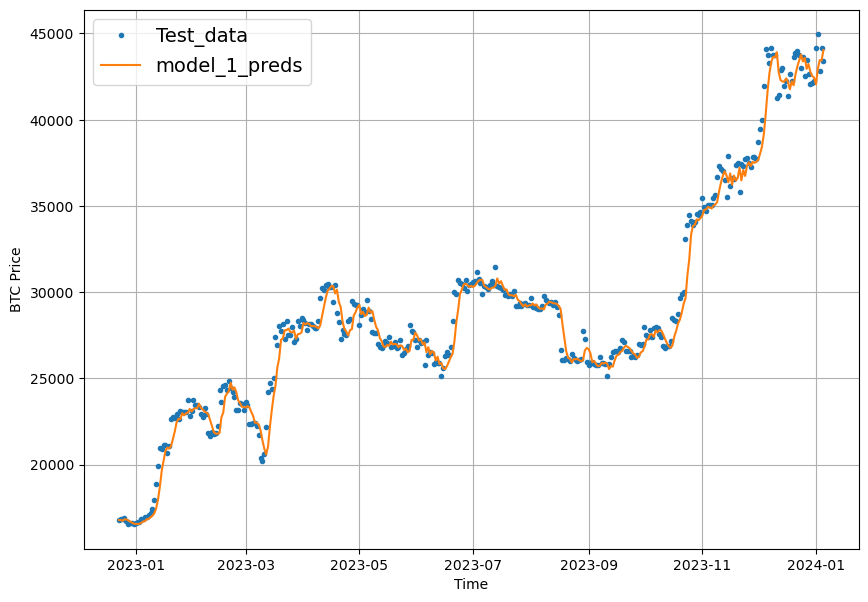

In [36]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model. 

We can't let this happen.

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

![bitcoin prices windowed for 30 days to predict a horizon of 1 day](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-price-window-for-one-month.png)
*Example of Bitcoin prices windowed for 30 days to predict a horizon of 1.*

> 🔑 **Note:** Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

In [37]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [38]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3368, 3368)

In [39]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2694, 674, 2694, 674)

Data prepared!

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [40]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=epochs,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Once again, training goes nice and fast.

Let's evaluate our model's performance.

In [41]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 896us/step - loss: 1698.5497


1698.5496826171875

Hmmm... is that the best it did?

How about we try loading in the best performing `model_2` which was saved to file thanks to our `ModelCheckpoint` callback.

In [42]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 934us/step - loss: 860.8613


860.8612670898438

Excellent! Loading back in the best performing model see's a performance boost.

But let's not stop there, let's make some predictions with `model_2` and then evaluate them just as we did before.

In [43]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

22/22 [==============================] - 0s 897us/step


In [44]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 860.8614,
 'mse': 1494389.8,
 'rmse': 1222.4524,
 'mape': 3.2058294,
 'mase': 1.6803135}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

Does this mean a smaller window size is better? (I'll leave this as a challenge you can experiment with)

How do the predictions look?

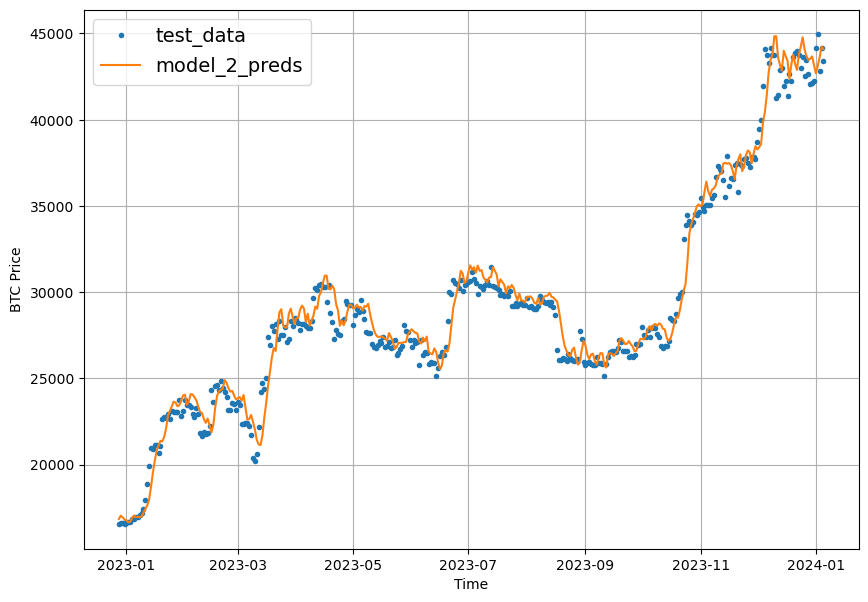

In [45]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [46]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3362, 3362)

And we'll split the full dataset windows into training and test sets.

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2689, 673, 2689, 673)

Now let's build, compile, fit and evaluate a model.

In [48]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


In [49]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 936us/step - loss: 2738.8943


2738.894287109375

To compare apples to apples (best performing model to best performing model), we've got to load in the best version of `model_3`. 

In [50]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 894us/step - loss: 1139.7075


1139.70751953125

In this case, the error will be higher because we're predicting 7 steps at a time. 

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [51]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

22/22 [==============================] - 0s 871us/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[38236.816, 38473.152, 39059.02 , 38209.582, 38672.797, 39630.51 ,
        37558.68 ],
       [39012.977, 38045.234, 38501.93 , 37969.76 , 39023.598, 39117.26 ,
        37389.137],
       [38734.973, 38291.234, 38740.145, 38305.34 , 38168.01 , 38298.785,
        37108.227],
       [41378.176, 40876.55 , 42015.95 , 40006.35 , 40865.652, 41522.02 ,
        39661.848],
       [42781.64 , 41955.79 , 42023.293, 42103.855, 42753.664, 42286.473,
        41751.543]], dtype=float32)>

In [52]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([3080.356  , 3388.3198 , 3319.3198 , 1927.9319 , 2685.6887 ,
        3616.019  , 4835.7573 , 3183.3298 , 1860.2428 , 1265.5675 ,
        1078.9186 , 1509.7533 ,  947.625  , 1022.0597 , 1281.5809 ,
        1995.3839 , 2474.4934 , 2383.774  , 2592.437  , 2391.3638 ,
        2016.8588 , 1483.6211 , 1775.0703 , 2485.0503 , 2764.077  ,
        3138.845  , 3500.5151 , 2629.8706 , 2314.2925 , 2107.4324 ,
        1125.0966 ,  769.70593,  887.5597 , 1482.375  , 1267.38   ,
        1897.3303 , 2209.119  , 2723.9136 , 3993.9744 , 4306.917  ,
        3186.9692 , 2830.8816 , 2297.342  , 2169.4731 , 2111.5698 ,
         694.21375,  586.57367,  583.3622 ,  894.53015,  636.5753 ,
         696.84094,  874.08203,  815.25946, 1342.053  , 1543.9933 ,
        1506.4191 , 1384.5999 , 1153.3192 , 1054.9838 , 1307.6189 ,
         490.42133,  579.0089 , 1009.5943 , 1204.3951 , 1410.0022 ,
        1587.4811 , 2799.7734 , 3438.318  , 5222.691  , 5275.3384 ,
        5544.8086 , 5787.2812 , 4639.439 

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [53]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [54]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1139.7075,
 'mse': 3001332.2,
 'rmse': 1304.3328,
 'mape': 4.2147665,
 'mase': 2.2253122}

Time to visualize.

If our prediction evaluation metrics were mutli-dimensional, how do you think the predictions will look like if we plot them?

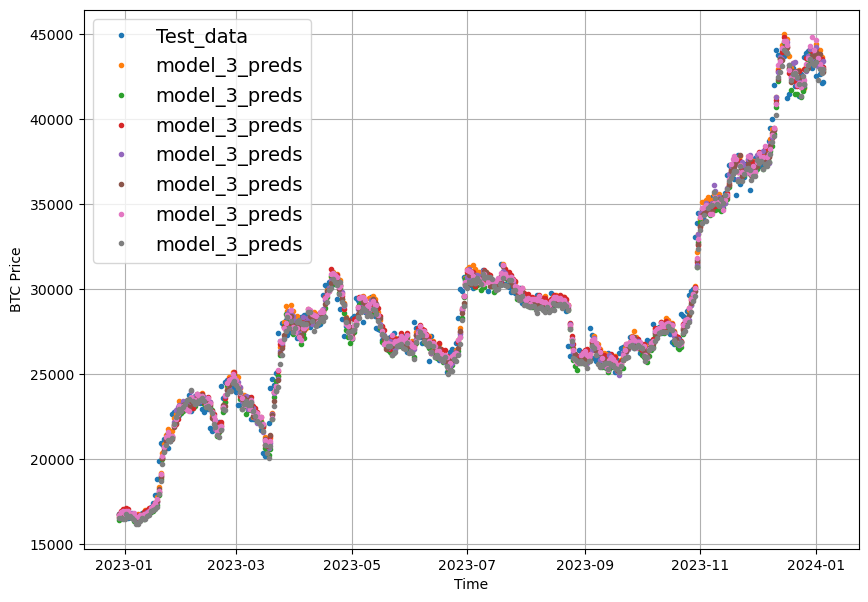

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 **Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

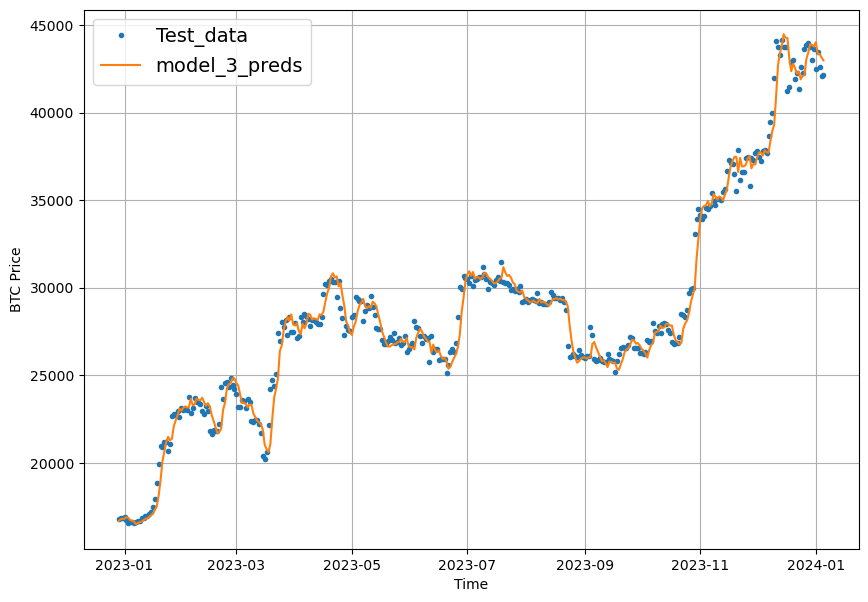

In [56]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Model 5: RNN (LSTM)

As you might've guessed, we can also use a recurrent neural network to model our sequential time series data.

> 📖 **Resource:** For more on the different types of recurrent neural networks you can use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

Let's reuse the same data we used for the Conv1D model, except this time we'll create an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data. 

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.








In [57]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=epochs,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [58]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 2ms/step - loss: 1873.8582


1873.858154296875

Now we've got the best performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [59]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

22/22 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[40498.566, 38839.93 , 39035.484, 38445.652, 38383.32 , 38513.77 ,
        38379.953],
       [40360.92 , 38642.89 , 38827.727, 38264.797, 38253.246, 38360.95 ,
        38189.7  ],
       [40099.37 , 38469.008, 38607.83 , 38149.207, 38182.1  , 38243.875,
        37998.555],
       [40531.793, 38932.74 , 39060.125, 38570.332, 38590.04 , 38593.496,
        38403.305],
       [40718.92 , 39079.91 , 39226.555, 38726.793, 38652.617, 38849.867,
        38496.617],
       [40908.895, 39215.87 , 39396.125, 38868.477, 38938.355, 39008.523,
        38706.87 ],
       [41000.535, 39287.125, 39481.195, 38943.168, 38968.332, 39047.227,
        38825.363],
       [40958.875, 39167.414, 39428.992, 38852.46 , 38896.023, 39026.83 ,
        38830.45 ],
       [41109.953, 39251.35 , 39594.51 , 38866.49 , 38899.133, 39216.137,
        38898.293],
       [41205.965, 39272.676, 39701.117, 38806.023, 38860.53 , 39193.254,
        38921.047]], dtype=floa

In [60]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 1873.8583,
 'mse': 6613602.0,
 'rmse': 2037.0082,
 'mape': 6.791309,
 'mase': 3.6587627}

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

Training and test multivariate time series datasets made! Time to build a model.

### Make predictions on the future

Let's predict the future and get rich!

Well... maybe not.

As you've seen so far, our machine learning models have performed quite poorly at predicting the price of Bitcoin (time series forecasting in open systems is typically a game of luck), often worse than the naive forecast.

That doesn't mean we can't use our models to *try* and predict into the future right?

To do so, let's start by defining a variable `INTO_FUTURE` which decides how many timesteps we'd like to predict into the future.

In [61]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)


*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction 
  * Eventually future predictions will be made using the model's own previous predictions as input

In [62]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

Nice! Time to bring BitPredict 💰📈 to life and make future forecasts of the price of Bitcoin.

> 🛠 **Exercise:** In terms of a forecasting model, what might another approach to our `make_future_forecasts()` function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction. 
>
> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc. 
>
> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

In [64]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be the last date of our dataset. 

In [65]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2024-01-05 00:00:00')

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

Look at that! We've now got a list of dates we can use to visualize our future Bitcoin predictions.

But to make sure the lines of the plot connect (try not running the cell below and then plotting the data to see what I mean), let's insert the last timestep and Bitcoin price of our training data to the `next_time_steps` and `future_forecast` arrays.

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

Time to plot!

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Compare Models

We've trained a bunch of models.

And if anything, we've seen just how poorly machine learning and deep learning models are at forecasting the price of Bitcoin (or any kind of open market value).

To highlight this, let's compare the results of all of the modelling experiments we've performed so far.

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                             
                             }).T
model_results.head(10)

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

The majority of our deep learning models perform on par or only slightly better than the naive model. And for the turkey model, changing a single data point destroys its performance.

> 🔑 **Note:** Just because one type of model performs better here doesn't mean it'll perform the best elsewhere (and vice versa, just because one model performs poorly here, doesn't mean it'll perform poorly elsewhere).

As I said at the start, this is not financial advice.

After what we've gone through, you'll now have some of the skills required to callout BS for any future tutorial or blog post or investment sales guide claiming to have model which is able to predict the futrue.

[Mark Saroufim's Tweet](https://twitter.com/marksaroufim/status/1366871736604532739?s=20) sums this up nicely (stock market forecasting with a machine learning model is just as reliable as palm reading).

![Mark Saroufim tweet on what forecasting with a machine learning model reminds him of: palm reading, basic heuristics, comparing calculations in the brain of different organisms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-mark-saroufim-tweet-forecasting-bs.png)
*Beware the tutorials or trading courses which claim to use some kind of algorithm to beat the market (an open system), they're likely a scam or the creator is very lucky and hasn't yet come across a turkey problem.*

Don't let these results get you down though, forecasting in a closed system (such as predicting the demand of electricity) often yields quite usable results.

If anything, this module teaches anti-knowledge. Knowing that forecasting methods usually *don't* perform well in open systems.

Plus, sometimes not knowing the future is a benefit. A known future is already the past.

